# PML Project

Data: 2022-01-11

Author: Jiajun He

Content: Structured Parameterization of the Decoder Networks, and trained by Full ELBO.
Also exploring the correlation among Recon.acc, Epoch & Rho

In [ ]:
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta

--2022-01-11 11:45:08--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2441075 (2.3M)
Saving to: ‘BLAT_ECOLX_1_b0.5_labeled.fasta’

BLAT_ECOLX_1_b0.5_l 100%[===================>]   2.33M  13.9MB/s    in 0.2s    

2022-01-11 11:45:09 (13.9 MB/s) - ‘BLAT_ECOLX_1_b0.5_labeled.fasta’ saved [2441075/2441075]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# parsing the FASTA file, codes from https://colab.research.google.com/github/wouterboomsma/pml_vae_project/blob/main/protein_vae_data_processing.ipynb
import os
import re
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd

# FASTA parser requires Biopython
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Retrieve protein alignment file
if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
        
# Retrieve file with experimental measurements
if not os.path.exists('BLAT_ECOLX_Ranganathan2015.csv'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
        
# Options
batch_size = 16

# Mapping from amino acids to integers
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22}
aa1 = "ACDEFGHIKLMNPQRSTVWYXZ-"

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']

def get_data(data_filename, calc_weights=False, weights_similarity_threshold=0.8):
    '''Create dataset from FASTA filename'''
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)       
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
        label = label_re.search(record.description).group(1)
        # Only use most common classes
        if label not in phyla:
            label = 'Other'
        labels.append(label)
                
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)
    
    phyla_lookup_table, phyla_idx = np.unique(labels, return_inverse=True)

    dataset = torch.utils.data.TensorDataset(*[seqs, torch.from_numpy(phyla_idx)])
    
    
    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(weights_similarity_threshold).sum(1).float()
            weights.append(w)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return dataset, weights


dataset, weights = get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_weighted = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=len(dataset)))

     |████████████████████████████████| 2.3 MB 5.1 MB/s 
--2022-01-13 12:11:40--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2441075 (2.3M)
Saving to: ‘BLAT_ECOLX_1_b0.5_labeled.fasta’

BLAT_ECOLX_1_b0.5_l 100%[===================>]   2.33M  3.05MB/s    in 0.8s    

2022-01-13 12:11:41 (3.05 MB/s) - ‘BLAT_ECOLX_1_b0.5_labeled.fasta’ saved [2441075/2441075]

--2022-01-13 12:11:41--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M  69.6KB/s  

In [ ]:
import torch
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [ ]:
global H
H = 2000

In [ ]:
class DeepSeq_Double(nn.Module):
    def __init__(self, input_size, latent_size, device):
        super().__init__()
        self.fc11 = nn.Linear(input_size, 1500) # 1500 is the number in the papar
        self.fc12 = nn.Linear(1500, 1500)
        self.fc131 = nn.Linear(1500, latent_size)
        self.fc132 = nn.Linear(1500, latent_size)

        self.fc21 = nn.Linear(latent_size, 100)
        self.fc22 = nn.Linear(100, H)
        

        self.lambd_tilde_loc = nn.Parameter(torch.tensor(0.))
        self.C_loc = nn.Parameter(torch.randn(23, 40))
        self.W_tilde_loc = nn.Parameter(torch.randn(input_size//23, 40, H)) # L * E * H
        self.S_tilde_loc = nn.Parameter(torch.randn(H//4, input_size//23) * 4 - 12)

        self._lambd_tilde_scale = nn.Parameter(torch.tensor(0.) - 4)
        self._C_scale = nn.Parameter(torch.zeros(23, 40) - 4)
        self._W_tilde_scale = nn.Parameter(torch.zeros(input_size//23, 40, H) - 4) # L * E * H
        self._S_tilde_scale = nn.Parameter(torch.zeros(H//4, input_size//23) - 4) # 
        
        self.b3 = nn.Parameter(torch.randn(input_size//23, 23))

        self.device = device
    
    def encoder(self, x):
        x = nn.functional.one_hot(x, num_classes=23).float().reshape(x.shape[0], -1)
        hidden = nn.ReLU()(self.fc11(x))
        hidden = nn.ReLU()(self.fc12(hidden))
        z_mu = self.fc131(hidden)
        z_sd = torch.exp(self.fc132(hidden))

        return z_mu, z_sd

    def decoder(self, z, sample=True):
        hidden = nn.ReLU()(self.fc21(z))
        hidden = nn.Sigmoid()(self.fc22(hidden)) 
        
        if sample:
            lambd_tilde = self.lambd_tilde_loc + nn.Softplus()(self._lambd_tilde_scale) * torch.randn_like(self.lambd_tilde_loc)
            C = self.C_loc + nn.Softplus()(self._C_scale) * torch.randn_like(self.C_loc)
            S_tilde = self.S_tilde_loc + nn.Softplus()(self._S_tilde_scale) * torch.randn_like(self.S_tilde_loc)
            W_tilde = self.W_tilde_loc + nn.Softplus()(self._W_tilde_scale) * torch.randn_like(self.W_tilde_loc)
        else:
            lambd_tilde = self.lambd_tilde_loc
            C = self.C_loc
            S_tilde = self.S_tilde_loc
            W_tilde = self.W_tilde_loc

        S = torch.cat([1 / (torch.exp(-S_tilde.clone()) + 1) for i in range(4)], dim=0)
        hidden = hidden[:, :, np.newaxis].expand([z.shape[0], H, S.shape[-1]])
        Sh = torch.permute((hidden * S), (0, 2, 1))[:, :, :,np.newaxis] # B * L * H * 1
        hidden = torch.log(torch.exp(lambd_tilde) + 1) * C @ W_tilde @ Sh #B L q 1
        hidden = hidden[:, :, :, 0] + self.b3 #B * L * q

        return hidden

    def forward(self, x, mc_samples=1, ann_factor=1., sample_params=True, calculate_global_KL=True):
        z_mu, z_sd = self.encoder(x)

        # prior distribution
        prior = torch.distributions.Normal(0., 1.)
        posterior = torch.distributions.Normal(z_mu, z_sd)

        # since both prior and posterior are diag-Gaussian, the KL divergence between q(z|x) and p(z) is just the sum of the KL divergence in each dimension
        KL_post_prior = torch.sum(torch.distributions.kl.kl_divergence(posterior, prior), dim=-1)

        # E_q[p(x|z)] (sum because p(x|z) = p(x1|z)p(x2|z)...)
        z = torch.randn_like(z_mu) * z_sd + z_mu
        x_logit = self.decoder(z, sample_params)
        Ep = torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        for sample in range(mc_samples-1):
            z = torch.randn_like(z_mu) * z_sd + z_mu
            x_logit = self.decoder(z, sample_params)
            Ep += torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        Ep = Ep / mc_samples

        ELBO = torch.sum(Ep - KL_post_prior)
        
        if calculate_global_KL:
            # lambda distribution
            prior_lambd_tilde = torch.distributions.Normal(0., 1.)
            posterior_lambda_tilde = torch.distributions.Normal(self.lambd_tilde_loc, nn.Softplus()(self._lambd_tilde_scale))
            KL_lambda_tilde = torch.sum(torch.distributions.kl.kl_divergence(posterior_lambda_tilde, prior_lambd_tilde))
            
            # C distribution
            prior_C = torch.distributions.Normal(0., 1.)
            posterior_C= torch.distributions.Normal(self.C_loc, nn.Softplus()(self._C_scale))
            KL_C = torch.sum(torch.distributions.kl.kl_divergence(posterior_C, prior_C))
            
            # W distribution
            prior_W_tilde = torch.distributions.Normal(0., 1.)
            posterior_W_tilde = torch.distributions.Normal(self.W_tilde_loc, nn.Softplus()(self._W_tilde_scale))
            KL_W_tilde = torch.sum(torch.distributions.kl.kl_divergence(posterior_W_tilde, prior_W_tilde))
            
            # S distribution
            prior_S_tilde = torch.distributions.Normal(-12.36, 4.)
            posterior_S_tilde = torch.distributions.Normal(self.S_tilde_loc, nn.Softplus()(self._S_tilde_scale))
            KL_S_tilde = torch.sum(torch.distributions.kl.kl_divergence(posterior_S_tilde, prior_S_tilde))
            
            ELBO = ELBO - (KL_lambda_tilde + KL_C + KL_W_tilde + KL_S_tilde) * ann_factor
        

        return ELBO, z_mu, z_sd
       
    
    # def forward(self, x, mc_samples=1, regularization_factor=.5, return_MAP=True):
    #     z_mu, z_sd = self.encoder(x)

    #     # prior distribution
    #     prior = torch.distributions.Normal(0., 1.)
    #     posterior = torch.distributions.Normal(z_mu, z_sd)

    #     # since both prior and posterior are diag-Gaussian, the KL divergence between q(z|x) and p(z) is just the sum of the KL divergence in each dimension
    #     KL_post_prior = torch.sum(torch.distributions.kl.kl_divergence(posterior, prior), dim=-1)

    #     # E_q[p(x|z)] (sum because p(x|z) = p(x1|z)p(x2|z)...)
    #     z = torch.randn_like(z_mu) * z_sd + z_mu
    #     x_logit = self.decoder(z)
    #     Ep = torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
    #     for sample in range(mc_samples-1):
    #         z = torch.randn_like(z_mu) * z_sd + z_mu
    #         x_logit = self.decoder(z)
    #         Ep += torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
    #     Ep = Ep / mc_samples

    #     ELBO = torch.sum(Ep - KL_post_prior)
        
    #     if return_MAP:
    #         # lambda distribution
    #         prior_lambd_tilde = torch.distributions.Normal(0., 1.)
    #         regular_lambda_tilde = torch.sum(prior_lambd_tilde.log_prob(self.lambd_tilde_loc))

    #         # C distribution
    #         prior_C = torch.distributions.Normal(0., 1.)
    #         regular_C = torch.sum(prior_C.log_prob(self.C_loc))

    #         # W distribution
    #         prior_W_tilde = torch.distributions.Normal(0., 1.)
    #         regular_W_tilde = torch.sum(prior_W_tilde.log_prob(self.W_tilde_loc))

    #         # S distribution
    #         prior_S_tilde = torch.distributions.Normal(-12.36, 4.)
    #         regular_S_tilde = torch.sum(prior_S_tilde.log_prob(self.S_tilde_loc))

    #         ELBO = ELBO + (regular_lambda_tilde + regular_C + regular_W_tilde + regular_S_tilde) * regularization_factor


    #     return ELBO, z_mu, z_sd

    # def forward_IWAE(self, x, mc_samples_l=1, mc_samples_k=10, regularization_factor=1, return_MAP=True):

    #     z_mu, z_sd = self.encoder(x)
        
    #     # prior distribution
    #     prior = torch.distributions.Normal(0., 1.)
    #     posterior = torch.distributions.Normal(z_mu, z_sd)

    #     LOG_Ps = []
    #     for s in range(mc_samples_l):
    #         log_p = []
    #         for sample in range(mc_samples_k):
    #             z = torch.randn_like(z_mu) * z_sd + z_mu
    #             x_logit = self.decoder(z)
    #             log_p.append(
    #                 torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1, keepdim=True) + \
    #                 torch.sum(prior.log_prob(z) - posterior.log_prob(z), dim=-1, keepdim=True))
    #         log_p = torch.cat(log_p, dim=-1)

    #         # To avoid numerical unstable
    #         log_p_max = torch.max(log_p, dim=-1, keepdim=True)[0]
    #         LOG_Ps.append(torch.log(torch.sum(torch.exp(log_p - log_p_max), dim=-1, keepdim=True) / mc_samples_k) + log_p_max)
    #     LOG_Ps = torch.sum(torch.cat(LOG_Ps, dim=-1), dim=-1) / mc_samples_l
        
    #     L_IWAE = torch.sum(LOG_Ps)
        
    #     if return_MAP:
    #         # lambda distribution
    #         prior_lambd_tilde = torch.distributions.Normal(0., 1.)
    #         regular_lambda_tilde = torch.sum(prior_lambd_tilde.log_prob(self.lambd_tilde_loc))

    #         # C distribution
    #         prior_C = torch.distributions.Normal(0., 1.)
    #         regular_C = torch.sum(prior_C.log_prob(self.C_loc))

    #         # W distribution
    #         prior_W_tilde = torch.distributions.Normal(0., 1.)
    #         regular_W_tilde = torch.sum(prior_W_tilde.log_prob(self.W_tilde_loc))

    #         # S distribution
    #         prior_S_tilde = torch.distributions.Normal(-12.36, 4.)
    #         regular_S_tilde = torch.sum(prior_S_tilde.log_prob(self.S_tilde_loc))

    #         L_IWAE = L_IWAE + (regular_lambda_tilde + regular_C + regular_W_tilde + regular_S_tilde) * regularization_factor


    #     return L_IWAE, z_mu, z_sd
    


In [ ]:
def train(model, dl, optimizer, device, ann_factor):
    ELBOs = []
    for i in dl:
        optimizer.zero_grad()
        ELBO, _, _ = model(i[0].to(device), mc_samples=1, ann_factor=1)
        loss = -ELBO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        ELBOs.append(ELBO.item())
    return sum(ELBOs) / len(ELBOs)

In [ ]:
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
deepseq = DeepSeq_Double(input_size, 30, device=DEVICE).to(DEVICE)
deepseq_dim_2 = DeepSeq_Double(input_size, 2, device=DEVICE).to(DEVICE)

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/fullyVI/" + "deepseq_DoubleVI_280.pkl"
# deepseq.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# global_params = [id(deepseq_dim_2.get_parameter(i)) for i in ["_lambd_tilde_scale", "_C_scale", "_W_tilde_scale", "_S_tilde_scale"]]
# base_params = filter(lambda p: id(p) not in global_params, deepseq_dim_2.parameters())
# optimizer = Adam([{'params': base_params}, 
#           {'params': [deepseq_dim_2.state_dict()[i] for i in ["_lambd_tilde_scale", "_C_scale", "_W_tilde_scale", "_S_tilde_scale"]], 'lr': 1e-7}], 
#           lr=4e-4)

optimizer = Adam(deepseq_dim_2.parameters(), lr=4e-4)

  0%|          | 0/50 [00:00<?, ?it/s]

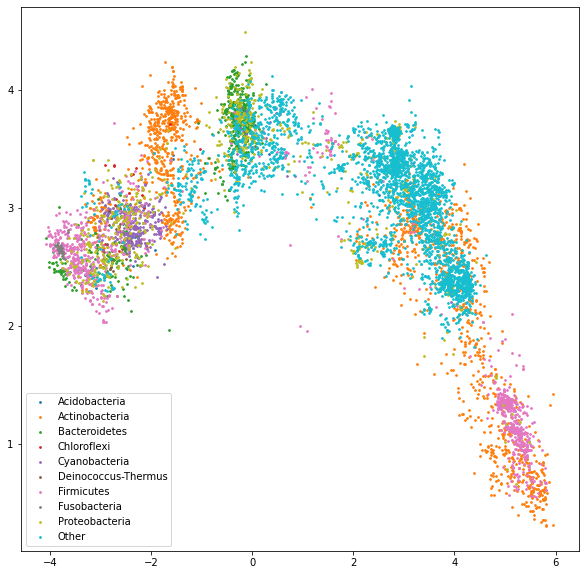

 20%|██        | 10/50 [04:20<17:18, 25.97s/it]

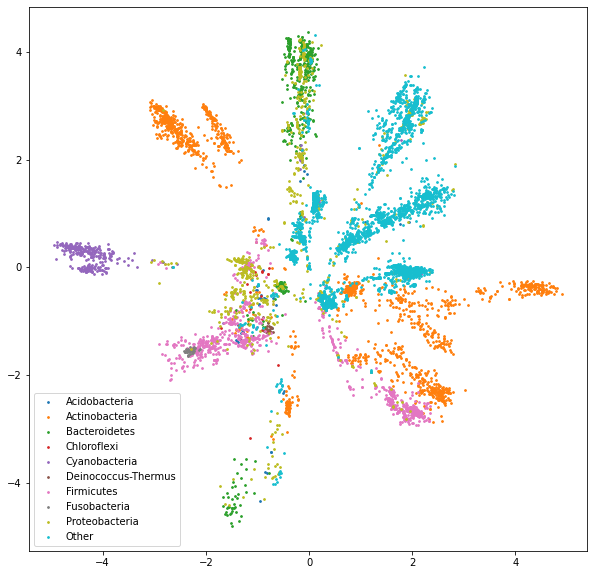

 40%|████      | 20/50 [08:41<12:59, 25.97s/it]

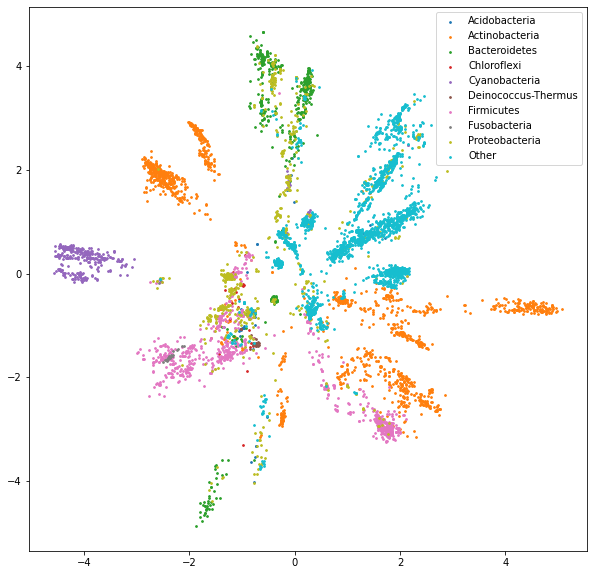

 60%|██████    | 30/50 [13:01<08:40, 26.01s/it]

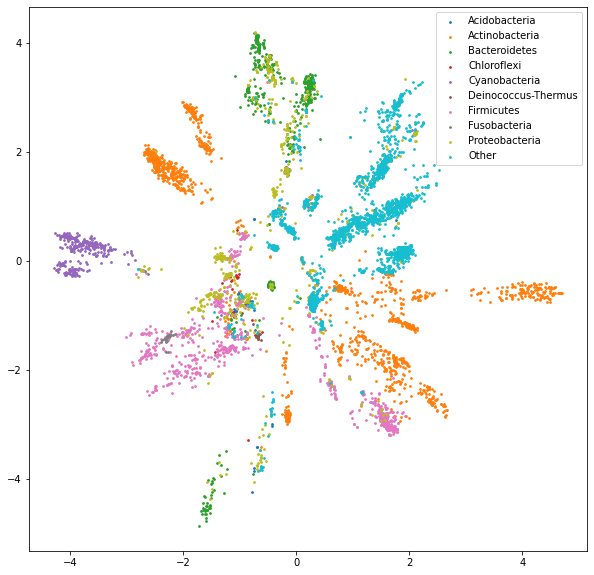

 80%|████████  | 40/50 [17:22<04:19, 25.96s/it]

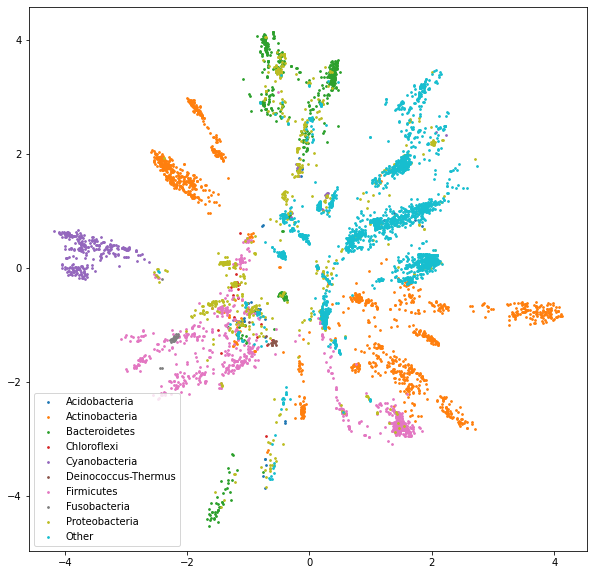

100%|██████████| 50/50 [21:42<00:00, 26.06s/it]


In [ ]:
# train the model
EPOCH = 50
ELBOs = []

for epoch in tqdm(range(EPOCH)):
    #ann_factor = min(0.01 + epoch * 0.01, 1)
    ELBOs.append(train(deepseq_dim_2, dataloader_weighted, optimizer, DEVICE, 1))

    if epoch % 10 == 0:
        Zs = []
        labels = []
        with torch.no_grad():
            for i in dataloader:
                z_mu, _ = deepseq_dim_2.encoder((i[0].to(DEVICE)))
                Zs.append(z_mu.cpu())
                labels.append(i[1])
        Zs = torch.cat(Zs).numpy()
        labels = torch.cat(labels).numpy()
        plt.rcParams["figure.figsize"] = (10, 10)
        for idx, name in enumerate(phyla):
            plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
        plt.legend()
        plt.show()

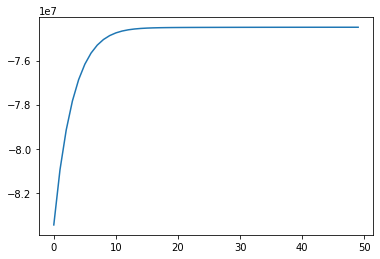

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs[:])

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/" + "deepseq_DoubleVI_dim_2.pkl"
# torch.save(deepseq_dim_2.state_dict(),PATH)
# deepseq_dim_2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

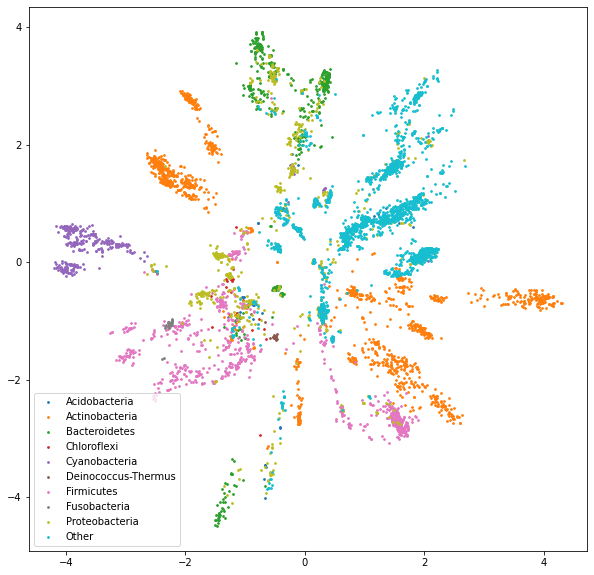

In [ ]:
Zs = []
labels = []
with torch.no_grad():
    for i in dataloader:
        z_mu, _ = deepseq_dim_2.encoder((i[0].to(DEVICE)))
        Zs.append(z_mu.cpu())
        labels.append(i[1])
Zs = torch.cat(Zs).numpy()
labels = torch.cat(labels).numpy()
plt.rcParams["figure.figsize"] = (10, 10)
for idx, name in enumerate(phyla):
    plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
plt.legend()
plt.show()

In [ ]:
# train the model

# global_params = [id(deepseq.get_parameter(i)) for i in ["_lambd_tilde_scale", "_C_scale", "_W_tilde_scale", "_S_tilde_scale"]]
# base_params = filter(lambda p: id(p) not in global_params, deepseq.parameters())
# optimizer = Adam([{'params': base_params}, 
#           {'params': [deepseq.state_dict()[i] for i in ["_lambd_tilde_scale", "_C_scale", "_W_tilde_scale", "_S_tilde_scale"]], 'lr': 1e-7}], 
#           lr=1e-4)
optimizer = Adam(deepseq.parameters(), lr=1e-4)
EPOCH = 201
ELBOs = []
for epoch in tqdm(range(EPOCH)):
    

    if epoch % 10 == 0:
        print(epoch, ":")
        # Check the reconstruct accuracy (make sure it learns normally)
        acc = []
        for i in range(len(dataset)):
            raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
            z_mu, _ = deepseq.encoder(raw_sequence)
            acc.append(torch.argmax(deepseq.decoder(z_mu, False), dim=-1) == raw_sequence)
        acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
        print("Reconstruct Accuracy:", acc)

        raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
        experiment_value = []
        predicted_value = []
        with torch.no_grad():
            log_x_wt_ELBO, _, _ = deepseq(raw_sequence, 50, calculate_global_KL=False)
            for (position, mutant_from), row in experimental_data.iterrows():
                assert aa1_to_index[mutant_from] == raw_sequence[0, position]
                for mutant_to, exp_value in row.iteritems():
                    if mutant_to != mutant_from:
                        new_sequence = raw_sequence.clone()
                        new_sequence[0, position] = aa1_to_index[mutant_to]
                        experiment_value.append(exp_value)
                        log_x_mt_ELBO, _, _ = deepseq(new_sequence, 50, calculate_global_KL=False)
                        predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())
        print(spearmanr(experiment_value, predicted_value))
        PATH = "/content/drive/MyDrive/PML-project/fullyVI/" + "deepseq_DoubleVI_%d.pkl"%epoch
        torch.save(deepseq.state_dict(),PATH)
        deepseq.load_state_dict(torch.load(PATH))
        

    ELBOs.append(train(deepseq, dataloader_weighted, optimizer, DEVICE, 1))


  0%|          | 0/201 [00:00<?, ?it/s]

0 :
Reconstruct Accuracy: 0.03541104775052691
SpearmanrResult(correlation=-0.05676704209358777, pvalue=5.942929870469914e-05)


  5%|▍         | 10/201 [25:25<2:13:14, 41.86s/it]

10 :
Reconstruct Accuracy: 0.5236677957820077
SpearmanrResult(correlation=0.5040410077318276, pvalue=0.0)


 10%|▉         | 20/201 [50:51<2:06:17, 41.87s/it]

20 :
Reconstruct Accuracy: 0.574720354905447
SpearmanrResult(correlation=0.5827572377598876, pvalue=0.0)


 15%|█▍        | 30/201 [1:16:16<1:59:01, 41.76s/it]

30 :
Reconstruct Accuracy: 0.5980764644406226
SpearmanrResult(correlation=0.6331837448366642, pvalue=0.0)


 20%|█▉        | 40/201 [1:41:43<1:52:21, 41.87s/it]

40 :
Reconstruct Accuracy: 0.615242960156512
SpearmanrResult(correlation=0.65265803837658, pvalue=0.0)


 25%|██▍       | 50/201 [2:07:08<1:45:22, 41.87s/it]

50 :
Reconstruct Accuracy: 0.6279193319153145
SpearmanrResult(correlation=0.6670139766798632, pvalue=0.0)


 30%|██▉       | 60/201 [2:32:32<1:38:32, 41.94s/it]

60 :
Reconstruct Accuracy: 0.639279156479099
SpearmanrResult(correlation=0.6745425537530054, pvalue=0.0)


 35%|███▍      | 70/201 [2:57:48<1:30:51, 41.62s/it]

70 :
Reconstruct Accuracy: 0.6506559468572526
SpearmanrResult(correlation=0.6801791455424745, pvalue=0.0)


 40%|███▉      | 80/201 [3:23:04<1:23:55, 41.62s/it]

80 :
Reconstruct Accuracy: 0.6594258186732539
SpearmanrResult(correlation=0.6870978001953111, pvalue=0.0)


 45%|████▍     | 90/201 [3:48:21<1:16:58, 41.61s/it]

90 :
Reconstruct Accuracy: 0.6669150138731887
SpearmanrResult(correlation=0.6912584834320454, pvalue=0.0)


 50%|████▉     | 100/201 [4:13:40<1:10:13, 41.72s/it]

100 :
Reconstruct Accuracy: 0.6719931244825427
SpearmanrResult(correlation=0.693119421232494, pvalue=0.0)


 55%|█████▍    | 110/201 [4:39:00<1:03:17, 41.73s/it]

110 :
Reconstruct Accuracy: 0.6794168801127694
SpearmanrResult(correlation=0.6985277115446643, pvalue=0.0)


 60%|█████▉    | 120/201 [5:04:21<56:17, 41.70s/it]  

120 :
Reconstruct Accuracy: 0.6834683165840351
SpearmanrResult(correlation=0.6971561951285951, pvalue=0.0)


 65%|██████▍   | 130/201 [5:29:43<49:22, 41.73s/it]

130 :
Reconstruct Accuracy: 0.6883447763711771
SpearmanrResult(correlation=0.7125463546825566, pvalue=0.0)


 70%|██████▉   | 140/201 [5:55:05<42:25, 41.72s/it]

140 :
Reconstruct Accuracy: 0.6932619541128042
SpearmanrResult(correlation=0.7004447046471096, pvalue=0.0)


 75%|███████▍  | 150/201 [6:20:27<35:31, 41.79s/it]

150 :
Reconstruct Accuracy: 0.6967515797596865
SpearmanrResult(correlation=0.7105351361055092, pvalue=0.0)


 80%|███████▉  | 160/201 [6:45:48<28:31, 41.73s/it]

160 :
Reconstruct Accuracy: 0.7002281174926271
SpearmanrResult(correlation=0.7115657851778515, pvalue=0.0)


 85%|████████▍ | 170/201 [7:11:06<21:33, 41.71s/it]

170 :
Reconstruct Accuracy: 0.7031685354915141
SpearmanrResult(correlation=0.7094256097977882, pvalue=0.0)


 90%|████████▉ | 180/201 [7:36:24<14:38, 41.81s/it]

180 :
Reconstruct Accuracy: 0.7048995332946836
SpearmanrResult(correlation=0.7080837135421162, pvalue=0.0)


 95%|█████████▍| 190/201 [8:01:44<07:38, 41.69s/it]

190 :
Reconstruct Accuracy: 0.7078767913476286
SpearmanrResult(correlation=0.7075323490340031, pvalue=0.0)


100%|█████████▉| 200/201 [8:27:04<00:41, 41.79s/it]

200 :
Reconstruct Accuracy: 0.7094827268620224
SpearmanrResult(correlation=0.7082984299995918, pvalue=0.0)


100%|██████████| 201/201 [8:48:32<00:00, 157.77s/it]


In [ ]:
for epoch in tqdm(range(201, 301)):
    

    if epoch % 10 == 0:
        print(epoch, ":")
        # Check the reconstruct accuracy (make sure it learns normally)
        acc = []
        for i in range(len(dataset)):
            raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
            z_mu, _ = deepseq.encoder(raw_sequence)
            acc.append(torch.argmax(deepseq.decoder(z_mu, False), dim=-1) == raw_sequence)
        acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
        print("Reconstruct Accuracy:", acc)

        raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
        experiment_value = []
        predicted_value = []
        with torch.no_grad():
            log_x_wt_ELBO, _, _ = deepseq(raw_sequence, 50, calculate_global_KL=False)
            for (position, mutant_from), row in experimental_data.iterrows():
                assert aa1_to_index[mutant_from] == raw_sequence[0, position]
                for mutant_to, exp_value in row.iteritems():
                    if mutant_to != mutant_from:
                        new_sequence = raw_sequence.clone()
                        new_sequence[0, position] = aa1_to_index[mutant_to]
                        experiment_value.append(exp_value)
                        log_x_mt_ELBO, _, _ = deepseq(new_sequence, 50, calculate_global_KL=False)
                        predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())
        print(spearmanr(experiment_value, predicted_value))
        PATH = "/content/drive/MyDrive/PML-project/fullyVI/" + "deepseq_DoubleVI_%d.pkl"%epoch
        torch.save(deepseq.state_dict(),PATH)
        #deepseq.load_state_dict(torch.load(PATH))
        

    ELBOs.append(train(deepseq, dataloader_weighted, optimizer, DEVICE, 1))

  9%|▉         | 9/100 [03:54<39:32, 26.07s/it]

210 :
Reconstruct Accuracy: 0.711674225340916
SpearmanrResult(correlation=0.7127269245330596, pvalue=0.0)


 19%|█▉        | 19/100 [29:22<55:56, 41.44s/it]  

220 :
Reconstruct Accuracy: 0.7136640729975976
SpearmanrResult(correlation=0.7053171183612793, pvalue=0.0)


 29%|██▉       | 29/100 [54:47<49:32, 41.87s/it]

230 :
Reconstruct Accuracy: 0.715351929158515
SpearmanrResult(correlation=0.7072353985826065, pvalue=0.0)


 39%|███▉      | 39/100 [1:20:14<42:36, 41.91s/it]

240 :
Reconstruct Accuracy: 0.7177756169254842
SpearmanrResult(correlation=0.709516766538212, pvalue=0.0)


 49%|████▉     | 49/100 [1:45:43<35:38, 41.92s/it]

250 :
Reconstruct Accuracy: 0.7198871337080678
SpearmanrResult(correlation=0.7079859017395432, pvalue=0.0)


 59%|█████▉    | 59/100 [2:11:17<28:38, 41.92s/it]

260 :
Reconstruct Accuracy: 0.7198042435864375


In [ ]:
# train the model

# global_params = [id(deepseq.get_parameter(i)) for i in ["_lambd_tilde_scale", "_C_scale", "_W_tilde_scale", "_S_tilde_scale"]]
# base_params = filter(lambda p: id(p) not in global_params, deepseq.parameters())
# optimizer = Adam([{'params': base_params}, 
#           {'params': [deepseq.state_dict()[i] for i in ["_lambd_tilde_scale", "_C_scale", "_W_tilde_scale", "_S_tilde_scale"]], 'lr': 1e-7}], 
#           lr=1e-4)

# ELBOs = []

In [ ]:
for epoch in tqdm(range(251, 351)):
    

    if epoch % 10 == 0:
        print(epoch, ":")
        # Check the reconstruct accuracy (make sure it learns normally)
        acc = []
        for i in range(len(dataset)):
            raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
            z_mu, _ = deepseq.encoder(raw_sequence)
            acc.append(torch.argmax(deepseq.decoder(z_mu, False), dim=-1) == raw_sequence)
        acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
        print("Reconstruct Accuracy:", acc)

        raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
        experiment_value = []
        predicted_value = []
        with torch.no_grad():
            log_x_wt_ELBO, _, _ = deepseq(raw_sequence, 50, calculate_global_KL=False)
            for (position, mutant_from), row in experimental_data.iterrows():
                assert aa1_to_index[mutant_from] == raw_sequence[0, position]
                for mutant_to, exp_value in row.iteritems():
                    if mutant_to != mutant_from:
                        new_sequence = raw_sequence.clone()
                        new_sequence[0, position] = aa1_to_index[mutant_to]
                        experiment_value.append(exp_value)
                        log_x_mt_ELBO, _, _ = deepseq(new_sequence, 50, calculate_global_KL=False)
                        predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())
        print(spearmanr(experiment_value, predicted_value))
        PATH = "/content/drive/MyDrive/PML-project/fullyVI/" + "deepseq_DoubleVI_%d.pkl"%epoch
        torch.save(deepseq.state_dict(),PATH)
        #deepseq.load_state_dict(torch.load(PATH))
        

    ELBOs.append(train(deepseq, dataloader_weighted, optimizer, DEVICE, 1))

  9%|▉         | 9/100 [03:43<37:37, 24.81s/it]

260 :
Reconstruct Accuracy: 0.7199646917166108
SpearmanrResult(correlation=0.7107667185735563, pvalue=0.0)


 19%|█▉        | 19/100 [26:41<52:04, 38.57s/it]  

270 :
Reconstruct Accuracy: 0.7216535173526349
SpearmanrResult(correlation=0.7064351453753022, pvalue=0.0)


 29%|██▉       | 29/100 [49:39<46:05, 38.96s/it]

280 :
Reconstruct Accuracy: 0.7234843710918035
SpearmanrResult(correlation=0.7133611801308662, pvalue=0.0)


 39%|███▉      | 39/100 [1:12:38<39:38, 38.98s/it]

290 :
Reconstruct Accuracy: 0.7257548817919002
SpearmanrResult(correlation=0.7062808300192475, pvalue=0.0)


 49%|████▉     | 49/100 [1:35:37<33:04, 38.92s/it]

300 :
Reconstruct Accuracy: 0.7257054385614541
SpearmanrResult(correlation=0.7106311575654198, pvalue=0.0)


 59%|█████▉    | 59/100 [1:58:36<26:36, 38.95s/it]

310 :
Reconstruct Accuracy: 0.7271993997010139
SpearmanrResult(correlation=0.709319092074446, pvalue=0.0)


 69%|██████▉   | 69/100 [2:21:37<20:07, 38.94s/it]

320 :
Reconstruct Accuracy: 0.7279187502302503


In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/" + "deepseq_DoubleVI.pkl"
# torch.save(deepseq.state_dict(),PATH)
# deepseq.load_state_dict(torch.load(PATH))

In [ ]:
# Check the reconstruct accuracy (make sure it learns normally)
acc = []
for i in range(len(dataset)):
    raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
    z_mu, _ = deepseq.encoder(raw_sequence)
    acc.append(torch.argmax(deepseq.decoder(z_mu, False), dim=-1) == raw_sequence)
acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
print("Reconstruct Accuracy:", acc)

In [ ]:
! wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv

# Read in the experimental data, codes by Wooter from https://colab.research.google.com/github/wouterboomsma/pml_vae_project/blob/main/protein_vae_data_processing.ipynb

def read_experimental_data(filename, alignment_data, measurement_col_name = '2500', sequence_offset=0):
    '''Read experimental data from csv file, and check that amino acid match those 
       in the first sequence of the alignment.
       
       measurement_col_name specifies which column in the csv file contains the experimental 
       observation. In our case, this is the one called 2500.
       
       sequence_offset is used in case there is an overall offset between the
       indices in the two files.
       '''
    
    measurement_df = pd.read_csv(filename, delimiter=',', usecols=['mutant', measurement_col_name])
    
    wt_sequence, wt_label = alignment_data[0]
    
    zero_index = None
    
    experimental_data = {}
    for idx, entry in measurement_df.iterrows():
        mutant_from, position, mutant_to = entry['mutant'][:1],int(entry['mutant'][1:-1]),entry['mutant'][-1:]  
        
        # Use index of first entry as offset (keep track of this in case 
        # there are index gaps in experimental data)
        if zero_index is None:
            zero_index = position
            
        # Corresponding position in our alignment
        seq_position = position-zero_index+sequence_offset
            
        # Make sure that two two inputs agree on the indices: the 
        # amino acids in the first entry of the alignment should be 
        # identical to those in the experimental file.
        assert mutant_from == aa1[wt_sequence[seq_position]]  
        
        if seq_position not in experimental_data:
            experimental_data[seq_position] = {}
        
        # Check that there is only a single experimental value for mutant
        assert mutant_to not in experimental_data[seq_position]
        
        experimental_data[seq_position]['pos'] = seq_position
        experimental_data[seq_position]['WT'] = mutant_from
        experimental_data[seq_position][mutant_to] = entry[measurement_col_name]
    
    experimental_data = pd.DataFrame(experimental_data).transpose().set_index(['pos', 'WT'])
    return experimental_data
        
        
experimental_data = read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset)
# For each of the entries in the dataframe above, you should calculate
# the corresponding difference in ELBO from your VAE, and then finally
# calculate a Spearman correlation between the two.

# # You can iterate over all experimental values like this:
# for (position, mutant_from), row in experimental_data.iterrows():
#     print(position, mutant_from)   # mutant from is the wild type (wt)
#     for mutant_to, exp_value in row.iteritems():
#         print("\t", mutant_to, exp_value) 

--2022-01-13 12:12:45--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv.1’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M  1.77MB/s    in 0.7s    

2022-01-13 12:12:46 (1.77 MB/s) - ‘BLAT_ECOLX_Ranganathan2015.csv.1’ saved [1216640/1216640]



In [ ]:
raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
experiment_value = []
predicted_value = []
with torch.no_grad():
    log_x_wt_ELBO, _, _ = deepseq(raw_sequence, 100, calculate_global_KL=False)
    for (position, mutant_from), row in tqdm(experimental_data.iterrows()):
        assert aa1_to_index[mutant_from] == raw_sequence[0, position]
        for mutant_to, exp_value in row.iteritems():
            if mutant_to != mutant_from:
                new_sequence = raw_sequence.clone()
                new_sequence[0, position] = aa1_to_index[mutant_to]
                experiment_value.append(exp_value)
                log_x_mt_ELBO, _, _ = deepseq(new_sequence, 100, calculate_global_KL=False)
                predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())

263it [36:55,  8.43s/it]


In [ ]:
spearmanr(experiment_value, predicted_value)

SpearmanrResult(correlation=0.7202019062646878, pvalue=0.0)